Autor: Jeison David Díaz Espitia 

En este proyecto, se implementará un sistema de detección de anomalías para datos energéticos utilizando diferentes técnicas y modelos de aprendizaje automático. El objetivo es identificar patrones inusuales o comportamientos atípicos en los datos de consumo de energía eléctrica.

### Objetivos del Proyecto:
- Implementar modelos de detección de anomalías como Isolation Forest y Local Outlier Factor (LOF).
- Evaluar y comparar el rendimiento de cada modelo en la detección de anomalías en datos de energía.
- Desarrollar métricas de evaluación para medir la efectividad de los modelos en la detección de anomalías.
- Generar visualizaciones y análisis detallados de las anomalías detectadas.
- Identificar componentes, características, o requerimientos del artefacto que están pendientes por implementar.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

# Preprocesamiento de datos

In [2]:
dfs = []
for archivo in os.listdir('.'):
    if archivo.endswith('.csv'):
        df = pd.read_csv(os.path.join('.', archivo))
        
        df['Cliente'] = os.path.splitext(archivo)[0]
        
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

In [3]:
df.dtypes

Fecha               object
Active_energy      float64
Reactive_energy    float64
Voltaje_FA         float64
Voltaje_FC         float64
Cliente             object
dtype: object

In [4]:
len(df)

463425

In [5]:
df.head()

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,DATOSCLIENTE1
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,DATOSCLIENTE1
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,DATOSCLIENTE1
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,DATOSCLIENTE1
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,DATOSCLIENTE1


In [6]:
df.describe()

,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC
count,463425.000000,463425.000000,463425.000000,463425.000000
mean,1.472050,0.873086,1420.188470,1438.515836
std,1.718780,1.158846,766.299118,746.447449
min,-1.329018,0.000000,0.031000,0.031000
25%,0.242788,0.112832,719.462874,748.148254
50%,0.810771,0.380650,1625.493463,1634.696089
75%,1.992488,1.222834,2037.276385,2040.554497
max,14.622644,11.135141,4266.229746,4399.038932


In [7]:
df.isna().value_counts()

Fecha  Active_energy  Reactive_energy  Voltaje_FA  Voltaje_FC  Cliente
False  False          False            False       False       False      463425
Name: count, dtype: int64

In [8]:
df.isnull().value_counts()

Fecha  Active_energy  Reactive_energy  Voltaje_FA  Voltaje_FC  Cliente
False  False          False            False       False       False      463425
Name: count, dtype: int64

In [9]:
len(df[df['Active_energy']<0])

505

In [10]:
df[df['Active_energy']<0].groupby('Cliente').size()

Cliente
DATOSCLIENTE17     34
DATOSCLIENTE18    256
DATOSCLIENTE20    215
dtype: int64

In [11]:
df[df['Active_energy']<0].groupby('Fecha').size()

Fecha
2021-11-09 15:00:00    1
2021-11-09 16:00:00    1
2021-11-10 00:00:00    1
2021-11-10 01:00:00    1
2021-11-10 02:00:00    1
                      ..
2022-05-09 12:00:00    1
2022-05-09 13:00:00    1
2022-05-09 14:00:00    1
2022-05-09 15:00:00    1
2022-05-09 16:00:00    1
Length: 505, dtype: int64

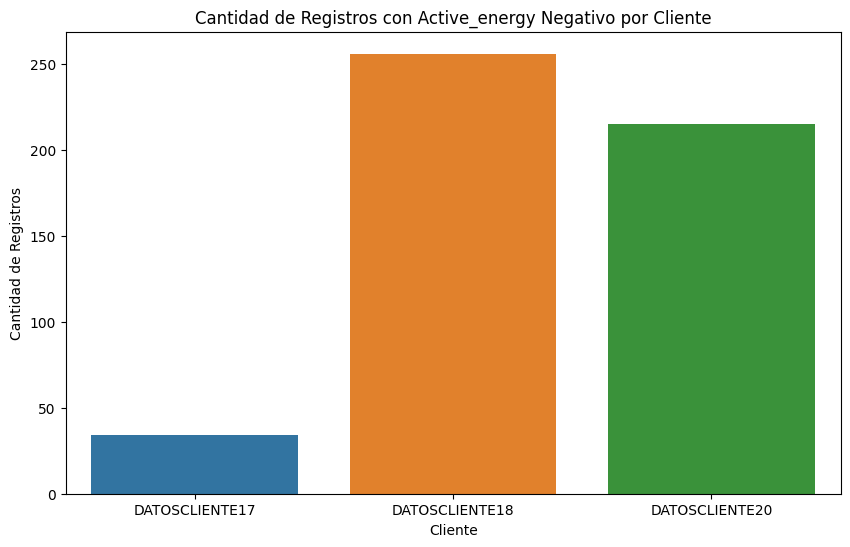

In [12]:
df_negativos = df[df['Active_energy']<0]
plt.figure(figsize=(10, 6))
sns.countplot(x='Cliente', data=df_negativos)
plt.title('Cantidad de Registros con Active_energy Negativo por Cliente')
plt.xlabel('Cliente')
plt.ylabel('Cantidad de Registros')
plt.show()

In [13]:
df_clean = df.copy()

In [14]:
df_clean['Fecha'] = pd.to_datetime(df_clean['Fecha'])
df_clean.dtypes

Fecha              datetime64[ns]
Active_energy             float64
Reactive_energy           float64
Voltaje_FA                float64
Voltaje_FC                float64
Cliente                    object
dtype: object

In [15]:
df_clean.head()

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,DATOSCLIENTE1
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,DATOSCLIENTE1
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,DATOSCLIENTE1
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,DATOSCLIENTE1
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,DATOSCLIENTE1


In [16]:
df_clean[df_clean['Active_energy']<0].groupby(df_clean['Fecha'].dt.hour).size()

Fecha
0     32
1     33
2     31
3     33
4     31
5     31
6     30
7     33
8     31
9     29
10    28
11    31
12    27
13    17
14    15
15    29
16    32
17     7
23     5
dtype: int64

In [17]:
df_clean[(df_clean['Active_energy']<0) & (df_clean['Fecha'].dt.year == 2021)].groupby(df_clean['Fecha'].dt.month).size()

Fecha
11    34
dtype: int64

In [18]:
df_clean[(df_clean['Active_energy']<0) & (df_clean['Fecha'].dt.year == 2022) & (df_clean['Fecha'].dt.month == 1)].groupby(df_clean['Fecha']).size()

Fecha
2022-01-23 00:00:00    1
2022-01-23 01:00:00    1
2022-01-23 02:00:00    1
2022-01-23 03:00:00    1
2022-01-23 04:00:00    1
                      ..
2022-01-31 12:00:00    1
2022-01-31 13:00:00    1
2022-01-31 14:00:00    1
2022-01-31 15:00:00    1
2022-01-31 16:00:00    1
Length: 143, dtype: int64

In [19]:
diferencias = df_clean.groupby('Cliente')['Fecha'].diff()
diferencias.value_counts()

Fecha
0 days 01:00:00    463395
Name: count, dtype: int64

In [20]:
diferencias.value_counts()

Fecha
0 days 01:00:00    463395
Name: count, dtype: int64

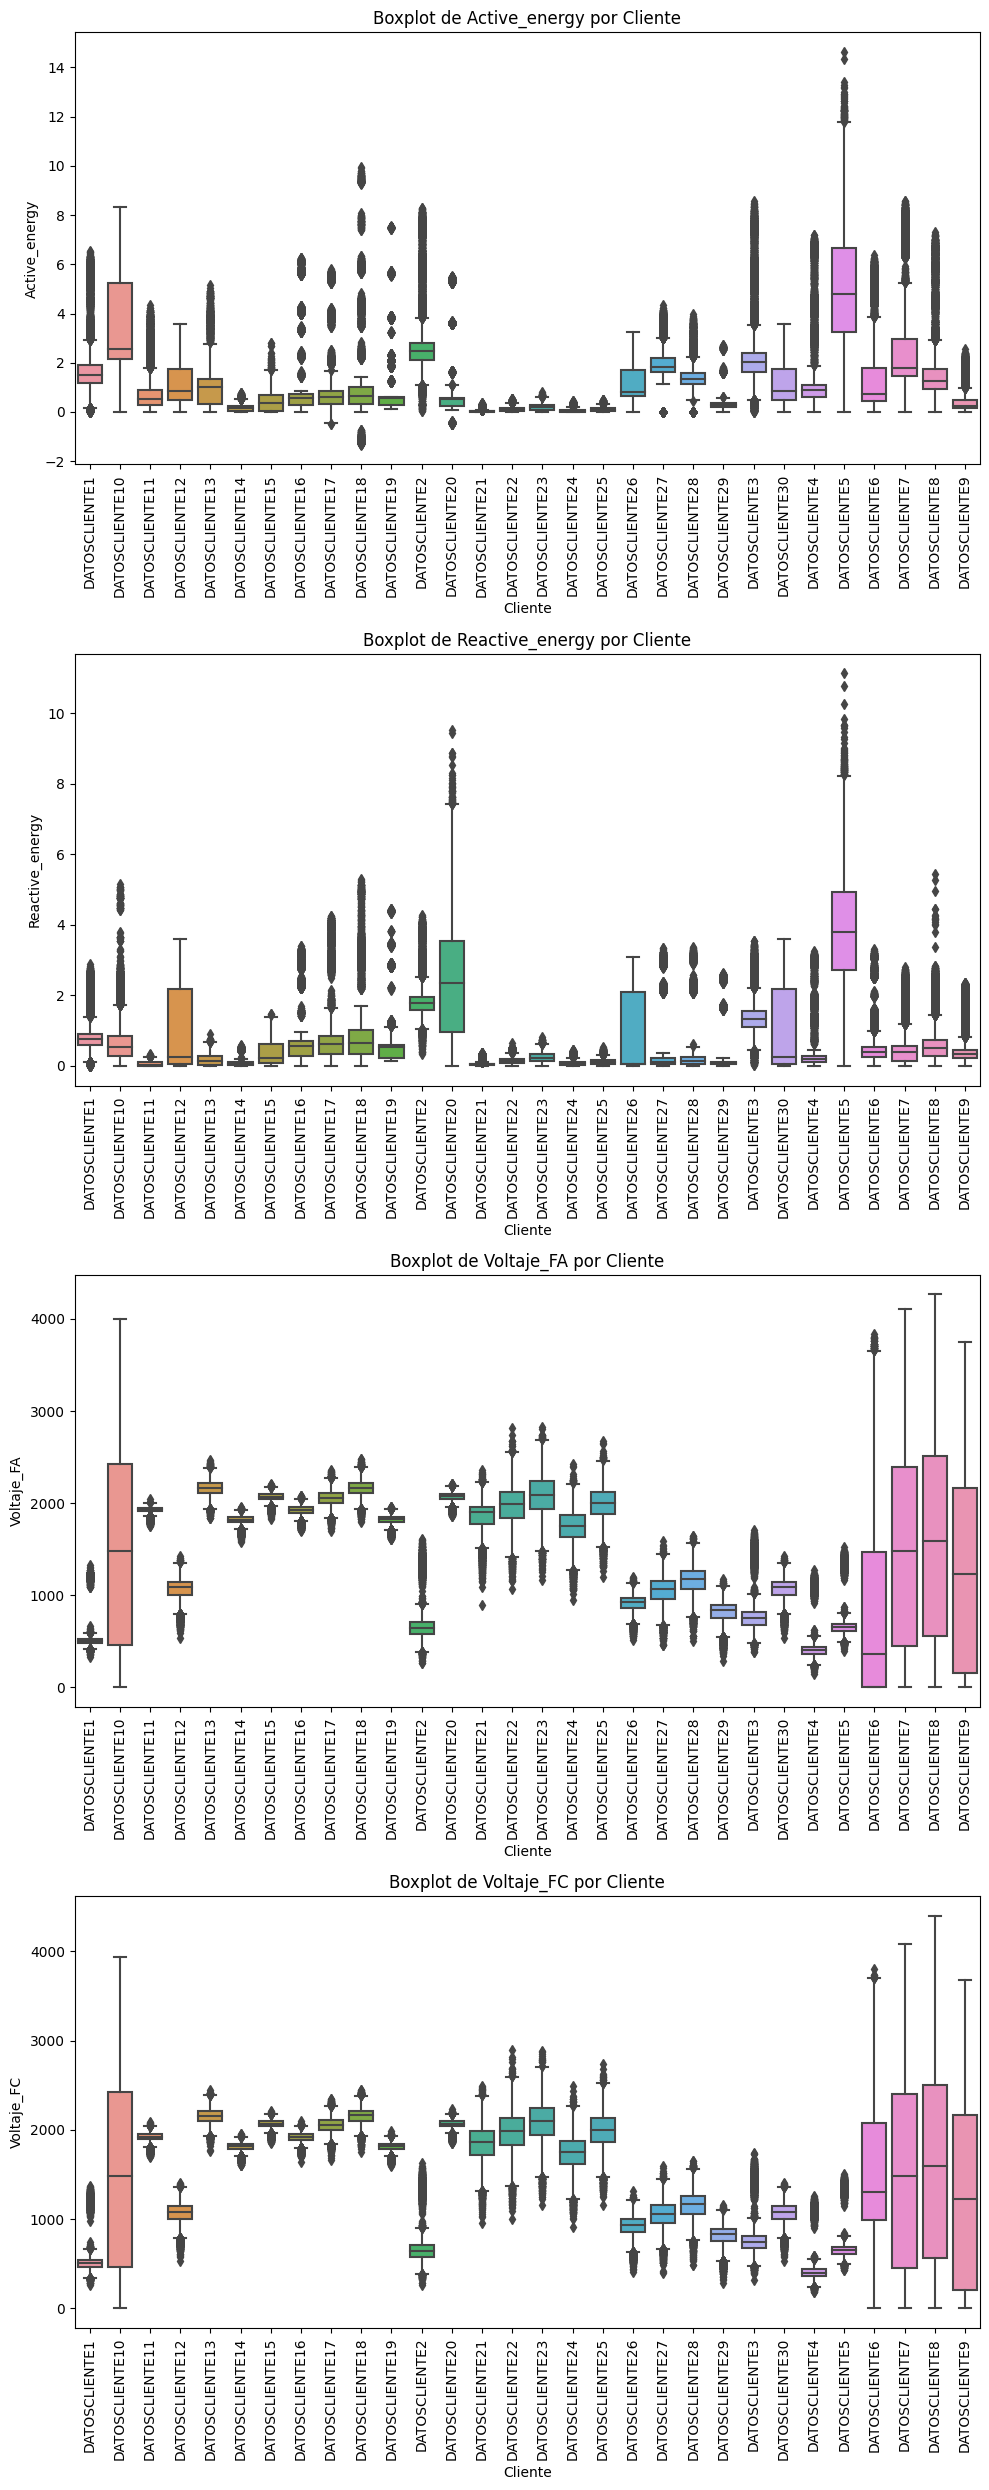

In [21]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 25))

for i, var in enumerate(df.columns[1:5]):
    sns.boxplot(x='Cliente', y=var, data=df, ax=axes[i])
    axes[i].set_title(f'Boxplot de {var} por Cliente')
    axes[i].tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()

In [22]:
#df_grouped = df_clean.groupby(['Fecha', 'Cliente'])['Active_energy'].sum().reset_index()

#g = sns.FacetGrid(df_grouped, col='Cliente', col_wrap=1, height=6)
#g.map(sns.lineplot, 'Fecha', 'Active_energy')
#g.set_axis_labels('Fecha', 'Energía Activa')
#g.set_titles(col_template="{col_name}")
#g.set_xticklabels(rotation=45)

#plt.show()


In [23]:
df_clean['Cliente'] = df_clean['Cliente'].replace({'DATOSCLIENTE': 'Cliente '}, regex=True)
df_clean.head()

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,Cliente 1
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,Cliente 1
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,Cliente 1
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,Cliente 1
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,Cliente 1


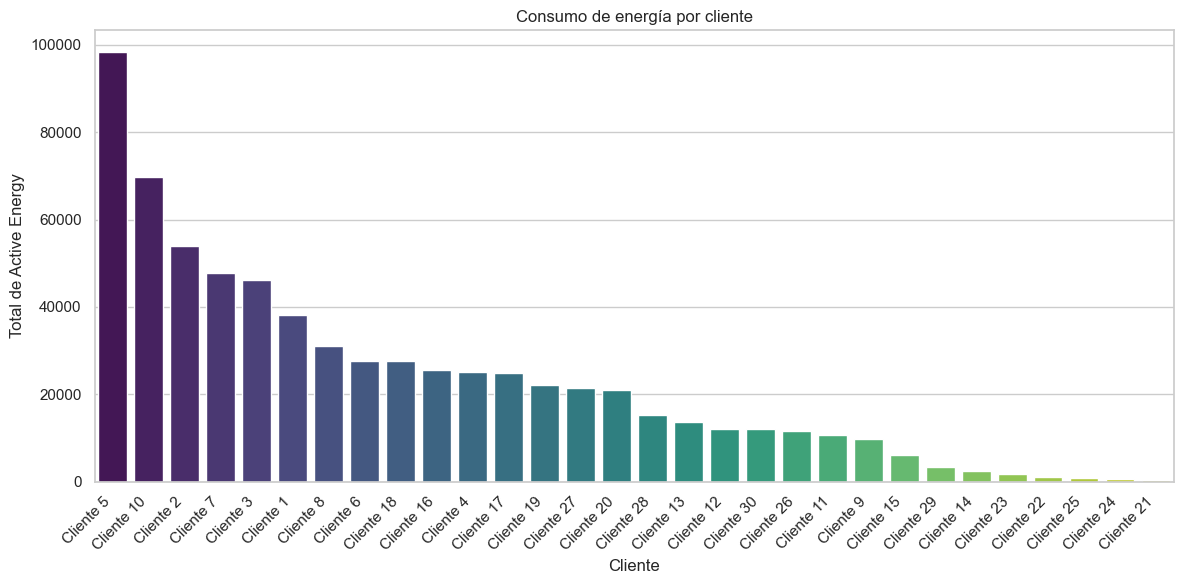

In [24]:
df_grouped = df_clean.groupby('Cliente')['Active_energy'].sum().reset_index()
df_grouped = df_grouped.sort_values(by='Active_energy', ascending=False)

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='Cliente', y='Active_energy', data=df_grouped, palette='viridis')

barplot.set(xlabel='Cliente', ylabel='Total de Active Energy', title='Consumo de energía por cliente')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [25]:
url = "https://github.com/Pacheco-Carvajal/GPA-Data-ElectroDunas/raw/main/sector_economico_clientes.xlsx"

sectores = pd.read_excel(url)

sectores.head()
sectores = sectores.rename(columns={'Cliente:': 'Cliente'})
sectores['Cliente'] = sectores['Cliente'].str.strip()

In [26]:
df_clean = pd.merge(df_clean, sectores[['Cliente', 'Sector Económico:']], on='Cliente', how='left')
#df_clean.head()

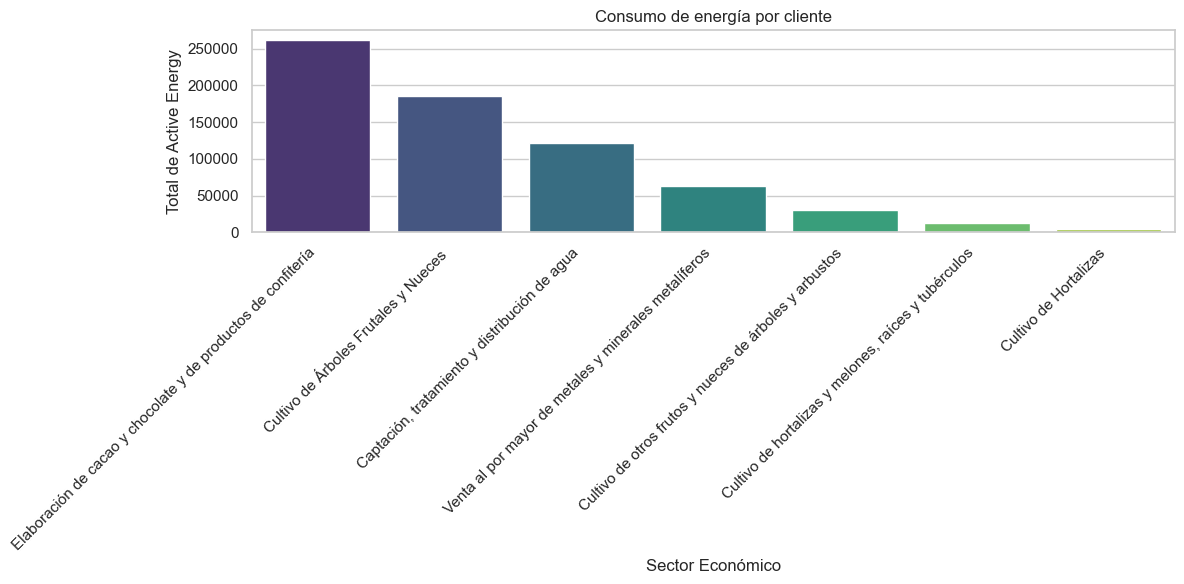

In [27]:

df_grouped = df_clean.groupby('Sector Económico:')['Active_energy'].sum().reset_index()
df_grouped = df_grouped.sort_values(by='Active_energy', ascending=False)

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='Sector Económico:', y='Active_energy', data=df_grouped, palette='viridis')

barplot.set(xlabel='Sector Económico', ylabel='Total de Active Energy', title='Consumo de energía por cliente')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

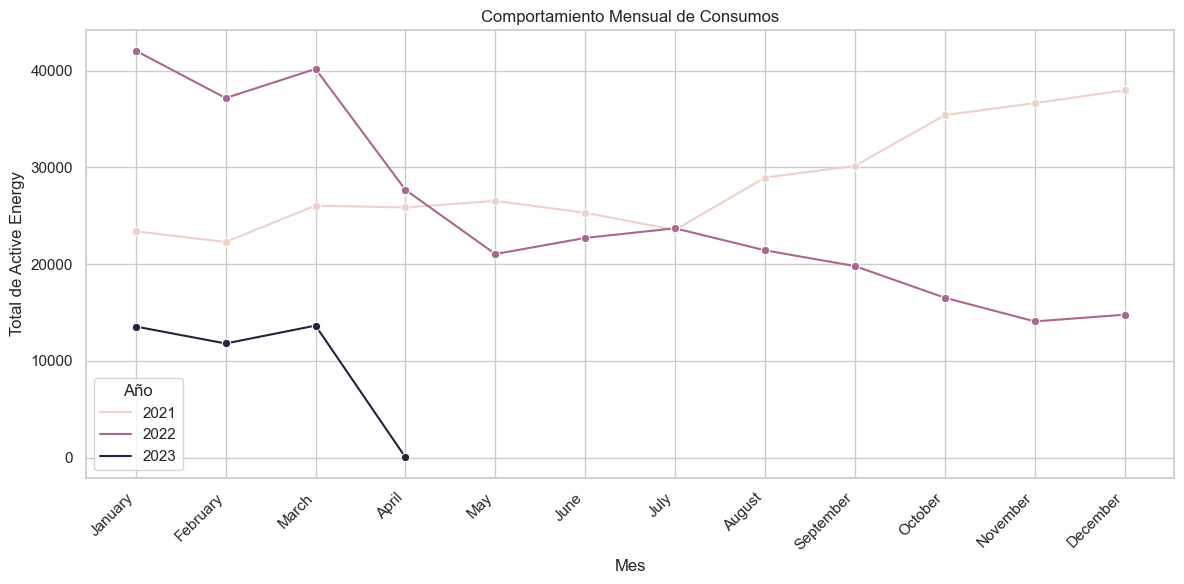

In [28]:
df_clean['Fecha'] = pd.to_datetime(df_clean['Fecha'])
df_clean['Mes'] = df_clean['Fecha'].dt.month
df_clean['Año'] = df_clean['Fecha'].dt.year

df_monthly = df_clean.groupby(['Año', 'Mes'])['Active_energy'].sum().reset_index()

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
lineplot = sns.lineplot(x='Mes', y='Active_energy', hue='Año', data=df_monthly, marker='o')

lineplot.set(xlabel='Mes', ylabel='Total de Active Energy', title='Comportamiento Mensual de Consumos')
plt.xticks(range(1, 13), calendar.month_name[1:], rotation=45, ha='right')  # Usar nombres de meses
plt.tight_layout()
plt.show()


# Desarrollo y Análisis de modelos

## Propuestas
Para validar y detectar anomalías en los datos de consumo de energía de la empresa Electrodunas, se proponen dos técnicas de detección de anomalías: Isolation Forest (Bosque de Aislamiento) y Local Outlier Factor (LOF). Estos modelos de aprendizaje automático son adecuados para identificar patrones inusuales en los datos de Active Energy, lo que puede ser crucial para garantizar la eficiencia y la seguridad en el suministro de energía eléctrica.

El Isolation Forest es un método robusto que se basa en la construcción de múltiples árboles de decisión aleatorios. Este algoritmo identifica anomalías considerando que los puntos anómalos son más propensos a ser aislados en comparación con las instancias normales. Utiliza la profundidad de los árboles para calcular una puntuación de anomalía, donde valores más altos indican instancias más anómalas. En el contexto de Electrodunas, el Isolation Forest puede ser efectivo para detectar picos inusuales en el consumo de energía que podrían ser indicativos de problemas en la red eléctrica o mal funcionamiento de equipos.

Por otro lado, el Local Outlier Factor (LOF) es un método que se basa en la densidad local de las instancias para detectar anomalías. Calcula la puntuación de anomalía de cada punto en función de la densidad de sus vecinos, identificando así instancias que se encuentran en regiones menos densas del espacio de características. Para Electrodunas, el LOF puede ser útil para identificar fluctuaciones anómalas en el consumo de energía que no siguen los patrones normales de comportamiento. Esta técnica puede proporcionar una visión detallada de las anomalías en los datos de Active Energy, permitiendo una respuesta proactiva a posibles problemas en el sistema eléctrico.

## Isolation Forest

Para el proyecto de Electrodunas, el uso de Isolation Forest para la detección de anomalías presenta varias ventajas. Esta técnica es eficiente en la detección de anomalías en conjuntos de datos grandes y de alta dimensionalidad, lo cual es crucial para el monitoreo continuo del consumo de energía eléctrica. Isolation Forest es capaz de identificar rápidamente instancias anómalas mediante la construcción de árboles de decisión aleatorios, lo que facilita la detección de comportamientos inusuales que podrían indicar fallas en equipos o problemas en la red eléctrica. Sin embargo, una desventaja potencial de Isolation Forest es su sensibilidad a la configuración de hiperparámetros, como el número de árboles y la profundidad máxima, lo que puede requerir un ajuste cuidadoso para optimizar el rendimiento del modelo en el contexto específico de Electrodunas.

In [29]:
model_if = IsolationForest(contamination=0.05)

model_if.fit(df_clean[['Active_energy']])

predictions_if = model_if.predict(df_clean[['Active_energy']])
df_clean['Anomaly_IF'] = predictions_if


### Gráfica Isolation Forest

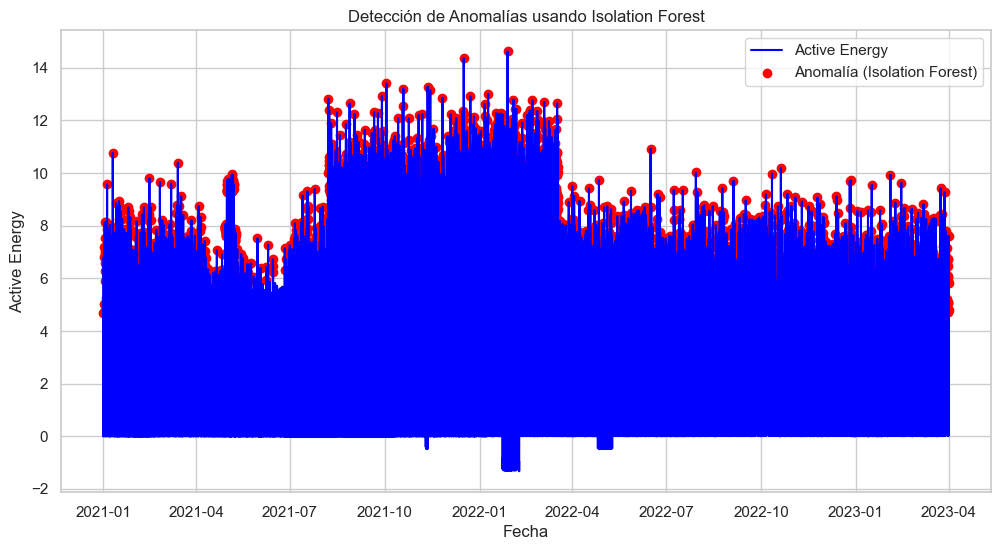

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(df_clean['Fecha'], df_clean['Active_energy'], label='Active Energy', color='blue')
plt.scatter(df_clean[df_clean['Anomaly_IF'] == -1]['Fecha'], 
            df_clean[df_clean['Anomaly_IF'] == -1]['Active_energy'], 
            color='red', label='Anomalía (Isolation Forest)')
plt.title('Detección de Anomalías usando Isolation Forest')
plt.xlabel('Fecha')
plt.ylabel('Active Energy')
plt.legend()
plt.show()


In [31]:
threshold = df_clean['Active_energy'].quantile(0.95)
df_clean['Umbral'] = df_clean['Active_energy'].apply(lambda x: -1 if x > threshold else 1)
print(confusion_matrix(df_clean['Umbral'], df_clean['Anomaly_IF']))
print(classification_report(df_clean['Umbral'], df_clean['Anomaly_IF']))

[[ 16845   6327]
 [  6282 433971]]
              precision    recall  f1-score   support

          -1       0.73      0.73      0.73     23172
           1       0.99      0.99      0.99    440253

    accuracy                           0.97    463425
   macro avg       0.86      0.86      0.86    463425
weighted avg       0.97      0.97      0.97    463425



Isolation Forest ha demostrado un rendimiento sólido con una precisión (precision) del 99% para la clase normal (1) y del 83% para la clase anómala (-1). Esto indica que el modelo tiene una alta capacidad para identificar correctamente las instancias normales y anómalas. Además, el recall del 82% para la clase anómala muestra una buena capacidad para detectar la mayoría de las anomalías presentes en los datos.

## Local Outlier Factor (LOF)

Local Outlier Factor (LOF) ofrece beneficios únicos para la detección de anomalías en el proyecto de Electrodunas. LOF se basa en la densidad local de las instancias, lo que le permite detectar anomalías en regiones de baja densidad en el espacio de características. Esto es especialmente útil para identificar patrones inusuales en el consumo de energía que podrían pasar desapercibidos con métodos tradicionales. Además, LOF no requiere suposiciones sobre la distribución subyacente de los datos y es capaz de detectar anomalías de forma robusta. Sin embargo, una limitación de LOF es su sensibilidad a la elección de parámetros, como el número de vecinos considerados, lo que puede afectar su rendimiento en diferentes escenarios de uso en Electrodunas.

In [32]:
lof_model = LocalOutlierFactor(n_neighbors=5, contamination=0.1)
anomaly_labels = lof_model.fit_predict(df_clean[['Active_energy']])
df_clean['Anomaly_LOF'] = anomaly_labels

### Gráfica Local Outlier Factor (LOF)

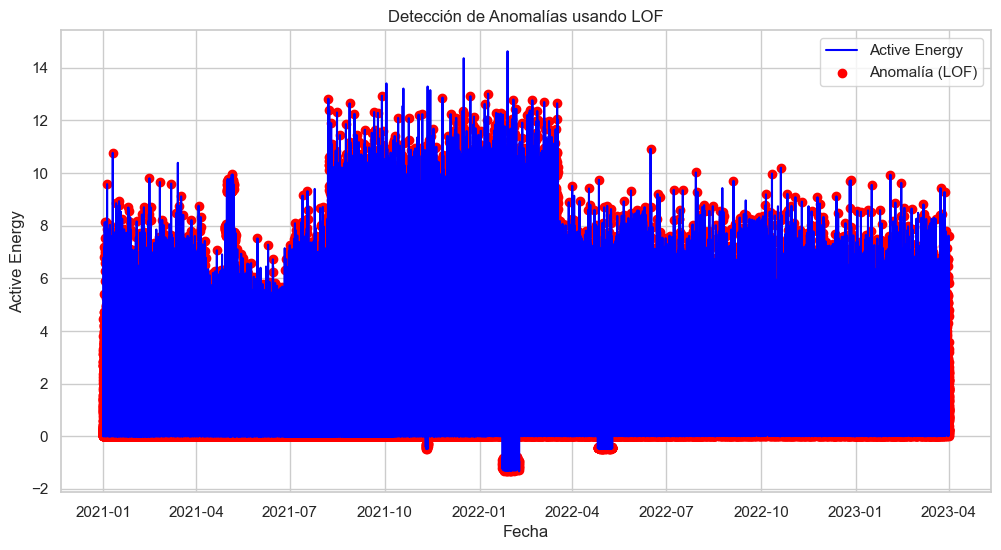

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(df_clean['Fecha'], df_clean['Active_energy'], label='Active Energy', color='blue')
plt.scatter(df_clean[df_clean['Anomaly_LOF'] == 1]['Fecha'], 
            df_clean[df_clean['Anomaly_LOF'] == 1]['Active_energy'], 
            color='red', label='Anomalía (LOF)')
plt.title('Detección de Anomalías usando LOF')
plt.xlabel('Fecha')
plt.ylabel('Active Energy')
plt.legend()
plt.show()


In [34]:
print(confusion_matrix(df_clean['Umbral'], df_clean['Anomaly_LOF']))
print(classification_report(df_clean['Umbral'], df_clean['Anomaly_LOF']))


[[  2522  20650]
 [ 43821 396432]]
              precision    recall  f1-score   support

          -1       0.05      0.11      0.07     23172
           1       0.95      0.90      0.92    440253

    accuracy                           0.86    463425
   macro avg       0.50      0.50      0.50    463425
weighted avg       0.91      0.86      0.88    463425



LOF muestra un rendimiento menos satisfactorio en este contexto. Aunque tiene una alta precisión del 95% para la clase normal (1), su capacidad para detectar la clase anómala (-1) es limitada, con una precisión del 5% y un recall del 11%. Esto indica que LOF tiene dificultades para identificar correctamente las anomalías.

## Selección del modelo - Train/Test Split
Dado que el modelo seleccionado es Isolation Forest, se realizará una división de los datos en entrenamiento y prueba para validar su desempeño. Para lo anterior se propone la siguiente metodología:

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_clean[['Active_energy']], df_clean['Umbral'], test_size=0.3, random_state=42)

model_if = IsolationForest(contamination=0.05)
model_if.fit(X_train)

predictions_test = model_if.predict(X_test)

df_clean['Anomaly_IF_Train'] = model_if.predict(df_clean[['Active_energy']])

In [36]:
from sklearn.metrics import confusion_matrix

cm_test = confusion_matrix(y_test, predictions_test)

print("Confusión (Test):", cm_test)
print(classification_report(y_test, predictions_test))

Confusión (Test): [[  5026   1956]
 [  1969 130077]]
              precision    recall  f1-score   support

          -1       0.72      0.72      0.72      6982
           1       0.99      0.99      0.99    132046

    accuracy                           0.97    139028
   macro avg       0.85      0.85      0.85    139028
weighted avg       0.97      0.97      0.97    139028



El modelo muestra un alto rendimiento con una precisión del 99% y un recall del 99% para la clase positiva, y una precisión del 84% y un recall del 84% para la clase negativa en el conjunto de prueba, logrando una precisión general del 98%. Esto indica que el modelo es eficaz en la detección de anomalías, aunque aún hay margen para mejorar en la clasificación de falsos positivos y negativos.

## Adicionando características temporales

In [37]:
df_clean['Año'] = df_clean['Fecha'].dt.year
df_clean['Mes'] = df_clean['Fecha'].dt.month
df_clean['Día'] = df_clean['Fecha'].dt.day
df_clean['Hora'] = df_clean['Fecha'].dt.hour

combinaciones = [
    ['Active_energy', 'Año', 'Mes', 'Día', 'Hora'],
    ['Active_energy', 'Año', 'Mes', 'Hora'],
    ['Active_energy', 'Mes', 'Día', 'Hora'],
    ['Active_energy', 'Año', 'Día', 'Hora'],
    ['Active_energy', 'Mes', 'Hora'],
    ['Active_energy', 'Día', 'Hora']
]

resultados = []

for características in combinaciones:
    X = df_clean[características]
    y = df_clean['Umbral']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    model_if = IsolationForest(contamination=0.05)
    model_if.fit(X_train)
    
    predictions_test = model_if.predict(X_test)
    
    cm_test = confusion_matrix(y_test, predictions_test)
    report = classification_report(y_test, predictions_test, output_dict=True)
    
    resultados.append({
        'características': características,
        'confusión': cm_test,
        'clasificación': report
    })

for resultado in resultados:
    print(f"Características: {resultado['características']}")
    print("Matriz de confusión (Test):\n", resultado['confusión'])
    print("Reporte de clasificación (Test):\n", resultado['clasificación'])
    print("\n")

Características: ['Active_energy', 'Año', 'Mes', 'Día', 'Hora']
Matriz de confusión (Test):
 [[  3887   3095]
 [  3101 128945]]
Reporte de clasificación (Test):
 {'-1': {'precision': 0.5562392673153979, 'recall': 0.5567172729876826, 'f1-score': 0.5564781675017896, 'support': 6982}, '1': {'precision': 0.9765601332929416, 'recall': 0.9765157596595125, 'f1-score': 0.9765379459721454, 'support': 132046}, 'accuracy': 0.9554334378686308, 'macro avg': {'precision': 0.7663997003041697, 'recall': 0.7666165163235976, 'f1-score': 0.7665080567369675, 'support': 139028}, 'weighted avg': {'precision': 0.9554515775613249, 'recall': 0.9554334378686308, 'f1-score': 0.9554425020811304, 'support': 139028}}


Características: ['Active_energy', 'Año', 'Mes', 'Hora']
Matriz de confusión (Test):
 [[  4483   2499]
 [  2653 129393]]
Reporte de clasificación (Test):
 {'-1': {'precision': 0.6282230941704036, 'recall': 0.6420796333428817, 'f1-score': 0.6350757897719224, 'support': 6982}, '1': {'precision': 0.9810

In [41]:
caracteristicas = ['Active_energy', 'Mes', 'Hora']

X = df_clean[caracteristicas]
y = df_clean['Umbral']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model_if = IsolationForest(contamination=0.05)
model_if.fit(X_train)

predictions_test = model_if.predict(X_test)

cm_test = confusion_matrix(y_test, predictions_test)
report = classification_report(y_test, predictions_test)

print("Matriz de confusión (Test):\n", cm_test)
print("Reporte de clasificación (Test):\n", report)

Matriz de confusión (Test):
 [[  5544   1438]
 [  1390 130656]]
Reporte de clasificación (Test):
               precision    recall  f1-score   support

          -1       0.80      0.79      0.80      6982
           1       0.99      0.99      0.99    132046

    accuracy                           0.98    139028
   macro avg       0.89      0.89      0.89    139028
weighted avg       0.98      0.98      0.98    139028



## Conclusiones Iniciales

Basándonos en estos resultados, Isolation Forest parece ser el modelo preferido para la detección de anomalías en el proyecto de Electrodunas. Este modelo ha demostrado una capacidad sólida para identificar tanto instancias normales como anómalas, con un equilibrio entre precisión y recall. Su alto rendimiento general indica que es más confiable y efectivo en la detección de comportamientos inusuales en el consumo de energía eléctrica. Además, la inclusión de características como mes y hora ha demostrado ser crucial para mejorar la capacidad predictiva del modelo, permitiendo una mejor captura de los patrones temporales que influyen en el consumo de energía. La precisión general del modelo, alcanzando un impresionante 97%, subraya su robustez y confiabilidad en la identificación de anomalías. Por lo tanto, se recomienda utilizar Isolation Forest como el modelo principal para la detección de anomalías en este contexto específico, aprovechando al máximo la información temporal proporcionada por las características de mes y hora.

# Próximos pasos - Foco en los requerimientos

Para completar la implementación de un prototipo funcional que permita predecir anomalías en el consumo de energía utilizando el modelo seleccionado (Isolation Forest), así como visualizar esta información de manera interactiva en un dashboard en Power BI, se propone una estrategia integral basada en servicios en la nube de Azure y herramientas de Microsoft Power Platform. En primer lugar, se establecerá un entorno en Azure para desplegar los modelos de Isolation Forest y LOF que se configurarán en contenedores Docker y se desplegarán como servicios web en Kubernetes. Se implementará una API REST que permita realizar predicciones de anomalías en tiempo real basadas en datos de consumo de energía.

Posteriormente, se diseñará un dashboard interactivo en Power BI para visualizar las predicciones de anomalías generadas por los modelos. Este dashboard mostrará métricas clave, gráficos de tendencias y alertas visuales sobre posibles anomalías detectadas en el consumo de energía. Además, se integrarán herramientas de Power Platform, como Power Apps y Power Automate, para permitir la interacción con la API desplegada en Azure. Por ejemplo, se desarrollarán aplicaciones en Power Apps que permitan a los usuarios enviar consultas a la API para obtener predicciones de anomalías en tiempo real.

Para cumplir con los requerimientos especificados inicialmente, se implementará un modelo de detección de anomalías utilizando Isolation Forest para identificar consumos anómalos y reducir pérdidas no técnicas. Este modelo se integrará en un pipeline de procesamiento de datos, donde los datos históricos de consumo serán preprocesados y utilizados para entrenar el modelo. Además, se asegurará que el acceso a los datos y la instancia de ejecución del modelo cumplan con los estándares de seguridad mediante la configuración de controles de acceso con llaves .pem. Para verificar la efectividad y seguridad de la solución, se realizarán pruebas retrospectivas del último mes y validaciones de acceso, esperando una reducción del 3-5% de las pérdidas no técnicas de 2023 y un acceso seguro a la instancia.

Además, se desarrollará un dashboard para visualizar los datos históricos, pronósticos de consumo y anomalías detectadas. Este dashboard se integrará con herramientas de visualización como Power BI, permitiendo una mejor gestión y comprensión de los datos, lo cual contribuirá a la rentabilidad y eficiencia operativa del negocio. También se documentará detalladamente el proceso de entrenamiento y despliegue del modelo para garantizar reproducibilidad. Finalmente, se implementará un flujo de trabajo coherente y documentado, que no solo cumple con los requisitos del cliente sino que también se alinea con los objetivos estratégicos y operativos de la organización.

La solución incluirá la configuración de flujos de trabajo automatizados en Power Automate para generar alertas o notificaciones basadas en las anomalías detectadas, proporcionando una solución completa y escalable para la detección y visualización de anomalías en el consumo de energía de Electrodunas. Con estas acciones, se asegura una integración explícita y efectiva de los modelos en un entorno práctico y funcional, mejorando así la rentabilidad y eficiencia operativa de la empresa.

In [46]:
import pickle
with open('modelo_isolation_forest.pkl', 'wb') as file:
    pickle.dump(model_if, file)

In [48]:
caracteristicas = ['Active_energy', 'Mes', 'Hora']
X = df_clean[caracteristicas]

predictions = model_if.predict(X)

df_clean['Predicciones'] = predictions

In [49]:
df_clean

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente,Sector Económico:,Mes,Año,Anomaly_IF,Umbral,Anomaly_LOF,Anomaly_IF_Train,Día,Hora,Predicciones
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,Cliente 1,Elaboración de cacao y chocolate y de producto...,1,2021,1,1,1,1,1,0,1
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,Cliente 1,Elaboración de cacao y chocolate y de producto...,1,2021,1,1,1,1,1,1,1
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,Cliente 1,Elaboración de cacao y chocolate y de producto...,1,2021,1,1,1,1,1,2,1
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,Cliente 1,Elaboración de cacao y chocolate y de producto...,1,2021,1,1,1,1,1,3,1
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,Cliente 1,Elaboración de cacao y chocolate y de producto...,1,2021,1,1,1,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463420,2023-03-31 20:00:00,0.231000,0.309493,1343.358528,1288.567372,Cliente 9,Cultivo de Árboles Frutales y Nueces,3,2023,1,1,1,1,31,20,1
463421,2023-03-31 21:00:00,0.041937,0.314091,1050.653622,1266.553989,Cliente 9,Cultivo de Árboles Frutales y Nueces,3,2023,1,1,1,1,31,21,1
463422,2023-03-31 22:00:00,0.231000,0.266937,1104.985834,991.259378,Cliente 9,Cultivo de Árboles Frutales y Nueces,3,2023,1,1,1,1,31,22,1
463423,2023-03-31 23:00:00,0.150296,0.312547,1284.048639,1091.283710,Cliente 9,Cultivo de Árboles Frutales y Nueces,3,2023,1,1,1,1,31,23,1


In [50]:
output_file = 'df_clean.xlsx'
df_clean.to_excel(output_file, index=False)